# מודל לחיזוי לקוחות בנקאיים פוטנציאלים אשר ירשמו לפיקדון לטווח

In [1]:
# Importing the necessary libraries
import numpy as np #importing numpy library
import pandas as pd  # To read the dataset as dataframe
import seaborn as sns # For Data Visualization 
import matplotlib.pyplot as plt # Necessary module for plotting purpose
%matplotlib inline
from sklearn.model_selection import train_test_split # For train-test split
# getting methods for confusion matrix, F1 score, Accuracy Score
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression # For logistic Regression
from sklearn.naive_bayes import GaussianNB # For Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier # For K-NN Classifier
from sklearn.svm import SVC # For support vector machine based classifier

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


## טעינת נתונים של לקוחות

In [3]:
df = pd.read_csv("bank/bank-full.csv", sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df = df.drop(['default','contact','duration','pdays','previous','poutcome','campaign','day','month', 'education'], axis=1)
df

,age,job,marital,balance,housing,loan,y
0,58,management,married,2143,yes,no,no
1,44,technician,single,29,yes,no,no
2,33,entrepreneur,married,2,yes,yes,no
3,47,blue-collar,married,1506,yes,no,no
4,33,unknown,single,1,no,no,no
...,...,...,...,...,...,...,...
45206,51,technician,married,825,no,no,yes
45207,71,retired,divorced,1729,no,no,yes
45208,72,retired,married,5715,no,no,yes
45209,57,blue-collar,married,668,no,no,no


## סימון משתנה מטרה
### y = 1 - לקוח נרשם לפיקדון
### y = 0 - לקוח לא נרשם לפיקדון

In [5]:
def yes_no_uk(x):
  '''used to transform y, housing, and loan'''
  if x=='yes':
    return(1)
  elif x=='no':
    return(0)
  elif x=='unknown':
    return(2)

df['loan'] = df['loan'].apply(yes_no_uk)
df['y'] = df['y'].apply(yes_no_uk)
df['housing'] = df['housing'].apply(yes_no_uk)

df

,age,job,marital,balance,housing,loan,y
0,58,management,married,2143,1,0,0
1,44,technician,single,29,1,0,0
2,33,entrepreneur,married,2,1,1,0
3,47,blue-collar,married,1506,1,0,0
4,33,unknown,single,1,0,0,0
...,...,...,...,...,...,...,...
45206,51,technician,married,825,0,0,1
45207,71,retired,divorced,1729,0,0,1
45208,72,retired,married,5715,0,0,1
45209,57,blue-collar,married,668,0,0,0


## התפלגות נתוני הגיל כתלות במשתנה המטרה

y,0,1
age,,
"(20, 30]",83.960767,16.039233
"(30, 40]",89.755187,10.244813
"(40, 50]",90.933357,9.066643
"(50, 60]",89.946696,10.053304


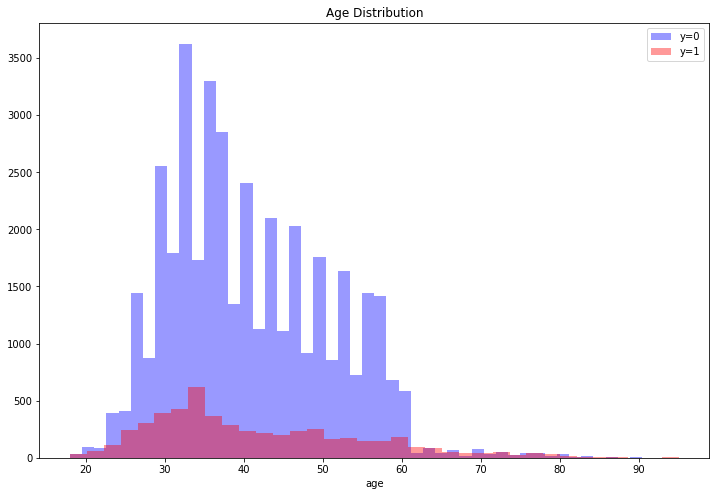

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['y'] == 0]['age'],kde=False, color='b', label='y=0')
sns.distplot(df[df['y'] == 1]['age'],kde=False, color='r',label='y=1')
plt.legend()
plt.title("Age Distribution")

age_cut = pd.cut(df['age'],bins=[20,30,40,50,60])
pd.crosstab(age_cut,df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני עו"ש כתלות במשתנה המטרה

y,0,1
balance,,
"(0, 10000]",87.461592,12.538408
"(10000, 20000]",83.333333,16.666667
"(20000, 30000]",85.815603,14.184397
"(30000, 40000]",83.333333,16.666667
"(40000, 50000]",90.000000,10.000000


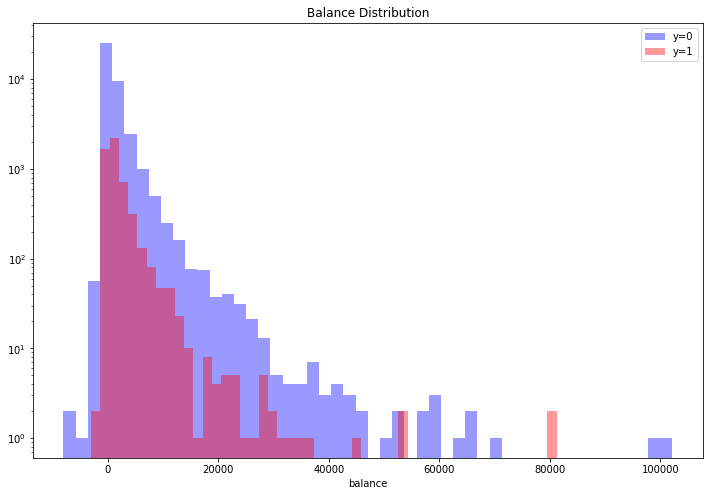

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['y'] == 0]['balance'],kde=False, color='b', label='y=0', hist_kws={'log':True})
sns.distplot(df[df['y'] == 1]['balance'],kde=False, color='r',label='y=1', hist_kws={'log':True})

plt.legend()
plt.title("Balance Distribution")

exp_cut = pd.cut(df['balance'],bins=[0,10000,20000,30000,40000,50000])
pd.crosstab(exp_cut,df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני מקצועות של הלקוחות כתלות במשתנה המטרה

y,0,1
job,,
admin.,87.797331,12.202669
blue-collar,92.725031,7.274969
entrepreneur,91.728312,8.271688
housemaid,91.209677,8.790323
management,86.244449,13.755551
retired,77.208481,22.791519
self-employed,88.157061,11.842939
services,91.116996,8.883004
student,71.321962,28.678038


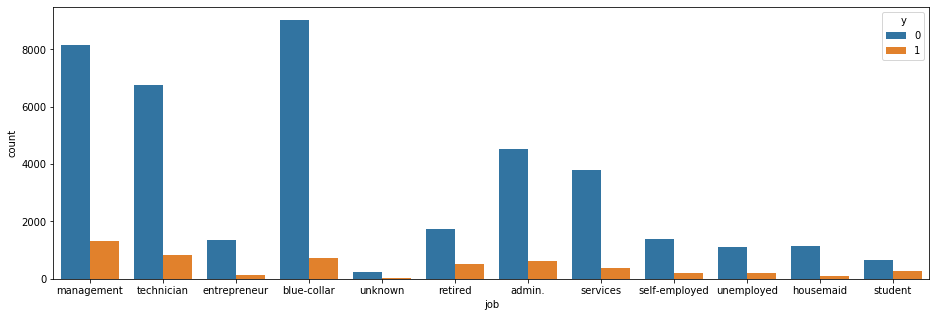

In [89]:
a4_dims = (15.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x='job',hue='y',data=df)

pd.crosstab(df['job'],df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני ההשכלה כתלות במשתנה המטרה

y,0,1
education,,
primary,91.373522,8.626478
secondary,89.440565,10.559435
tertiary,84.993610,15.006390
unknown,86.429725,13.570275


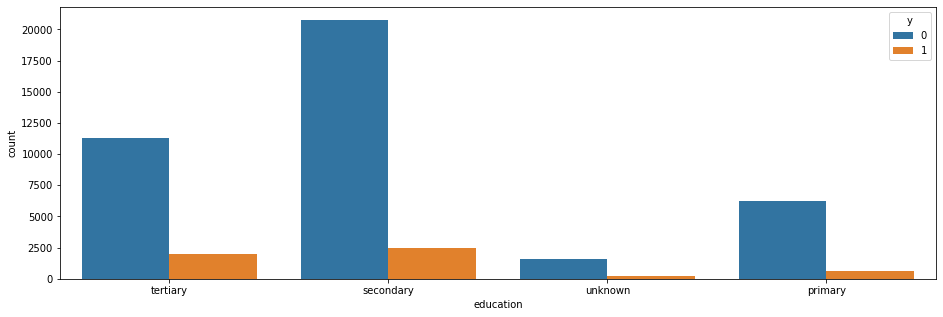

In [92]:
a4_dims = (15.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x='education',hue='y',data=df)

pd.crosstab(df['education'],df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני מצב משפחתי כתלות במשתנה המטרה

y,0,1
marital,,
divorced,88.054542,11.945458
married,89.876534,10.123466
single,85.050821,14.949179


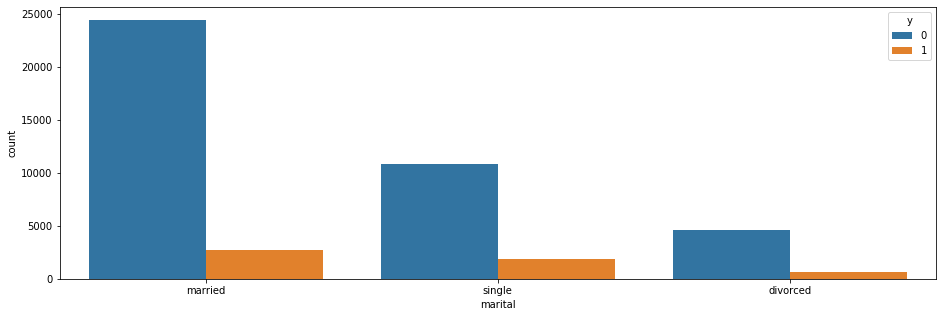

In [93]:
a4_dims = (15.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x='marital',hue='y',data=df)

pd.crosstab(df['marital'],df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני דיור כתלות במשתנה המטרה

y,0,1
housing,,
0,83.297645,16.702355
1,92.300040,7.699960


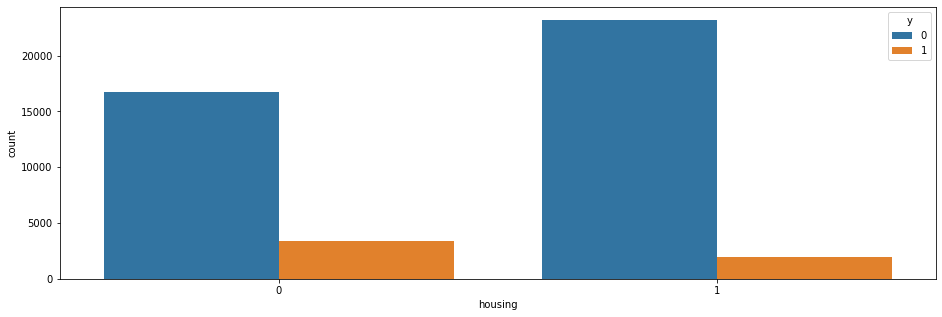

In [94]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x='housing',hue='y',data=df)

pd.crosstab(df['housing'],df['y']).apply(lambda r: r/r.sum()*100, axis=1)

## התפלגות נתוני לקוחות עם הלוואות כתלות במשתנה המטרה

y,0,1
loan,,
0,87.344273,12.655727
1,93.318609,6.681391


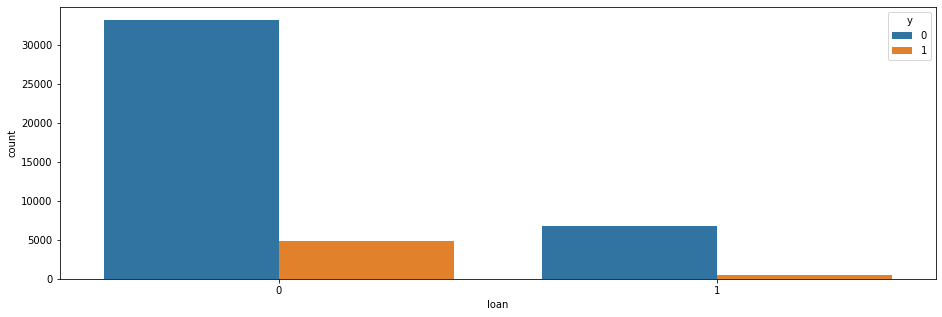

In [95]:
a4_dims = (15.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x='loan',hue='y',data=df)

pd.crosstab(df['loan'],df['y']).apply(lambda r: r/r.sum()*100, axis=1)

In [99]:
df.corr().loc['y',:].sort_values(ascending=False)

y          1.000000
balance    0.052838
age        0.025155
loan      -0.068185
housing   -0.139173
Name: y, dtype: float64

## נתוני לקוחות

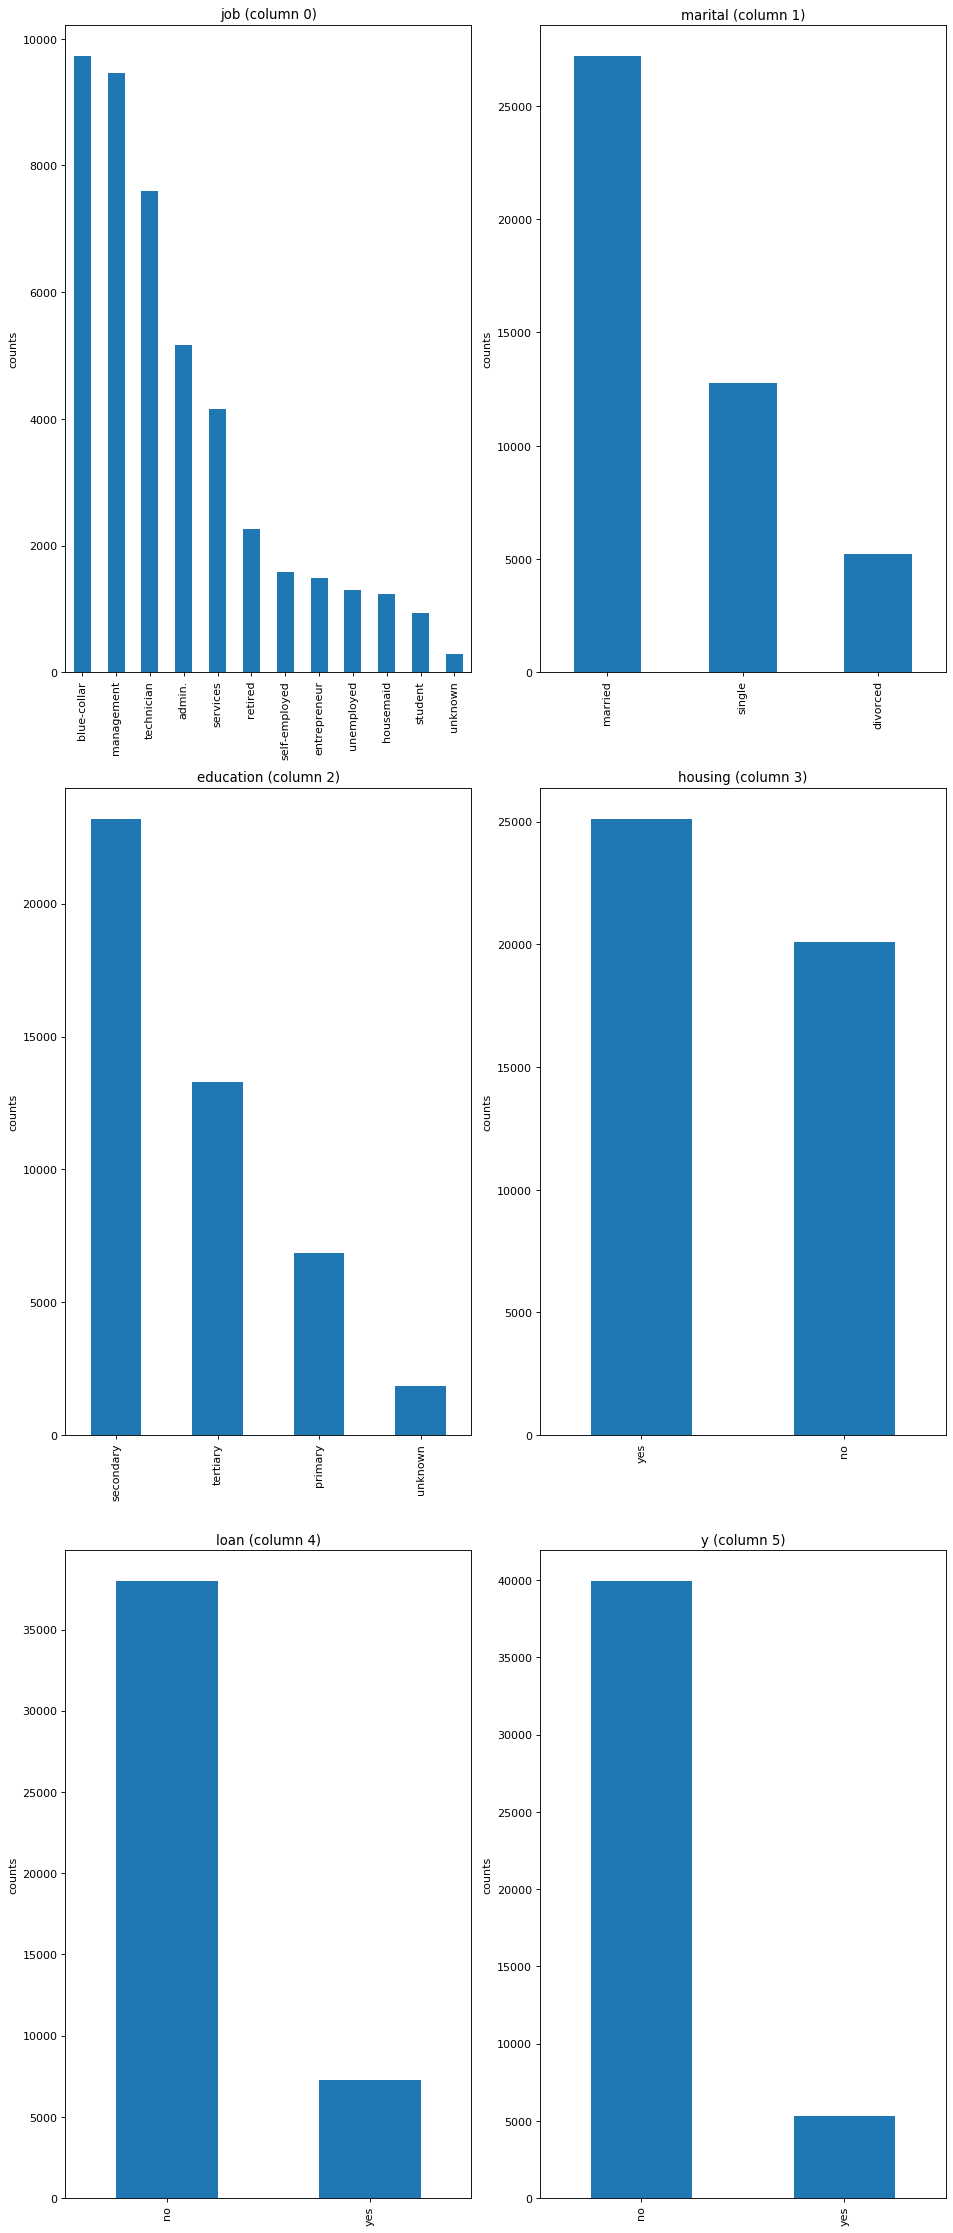

In [20]:
plotPerColumnDistribution(df, 6, 2)

## הכנת נתונים לצורך בניית המודל

In [17]:
df = pd.get_dummies(df, columns=["job"])
df = pd.get_dummies(df, columns=["marital"])
# df = pd.get_dummies(df, columns=["education"])

df

,age,balance,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,2143,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,44,29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,33,2,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,47,1506,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
45207,71,1729,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
45208,72,5715,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
45209,57,668,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [18]:
df_x = df.drop(['y'], axis=1)

df_y = df['y']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.30, random_state = 7)

In [20]:
# create model using constructor
NBModel = GaussianNB()
# fit the model to training set
NBModel.fit(X_train,y_train)
# Predict the test data to get y_pred
y_pred = NBModel.predict(X_test)
# get accuracy of model
nb_acc_score = accuracy_score(y_test,y_pred)
# get F1-score of model
nb_f1_score = f1_score(y_test,y_pred) 
# get the confusion matrix
nb_confmat = confusion_matrix(y_test,y_pred)
# get the classification report
nb_classrep = classification_report(y_test,y_pred)

print("The accuracy of the model is {} %".format(nb_acc_score*100))
print("The f1-score of the model is {} %".format(nb_f1_score*100))
print("The confusion matrix for Naive Bayes classifier is: \n",nb_confmat)
print("Detailed classification report for Naive Bayes classifier is: \n",nb_classrep)

The accuracy of the model is 83.07283987024476 %
The f1-score of the model is 21.2079615648593 %
The confusion matrix for Naive Bayes classifier is: 
 [[10959  1071]
 [ 1225   309]]
Detailed classification report for Naive Bayes classifier is: 
               precision    recall  f1-score   support

           0       0.90      0.91      0.91     12030
           1       0.22      0.20      0.21      1534

    accuracy                           0.83     13564
   macro avg       0.56      0.56      0.56     13564
weighted avg       0.82      0.83      0.83     13564



In [23]:
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=500, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

y_pred = clf_gini.predict(X_test)
# get accuracy of model
svm_acc_score = accuracy_score(y_test,y_pred)
# get F1-score of model
svm_f1_score = f1_score(y_test,y_pred) 
# get the confusion matrix
svm_confmat = confusion_matrix(y_test,y_pred)
# get the classification report
svm_classrep = classification_report(y_test,y_pred)

print("The accuracy of the model is {} %".format(svm_acc_score*100))
print("The f1-score of the model is {} %".format(svm_f1_score*100))
print("The confusion matrix for SVM classifier is: \n",svm_confmat)
print("Detailed classification report for SVM classifier is: \n",svm_classrep)


The accuracy of the model is 86.36095547036273 %
The f1-score of the model is 22.723475355054305 %
The confusion matrix for SVM classifier is: 
 [[11442   588]
 [ 1262   272]]
Detailed classification report for SVM classifier is: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93     12030
           1       0.32      0.18      0.23      1534

    accuracy                           0.86     13564
   macro avg       0.61      0.56      0.58     13564
weighted avg       0.83      0.86      0.85     13564



In [24]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=100, min_samples_leaf=3)
clf_entropy.fit(X_train, y_train)

y_pred = clf_entropy.predict(X_test)
# get accuracy of model
svm_acc_score = accuracy_score(y_test,y_pred)
# get F1-score of model
svm_f1_score = f1_score(y_test,y_pred) 
# get the confusion matrix
svm_confmat = confusion_matrix(y_test,y_pred)
# get the classification report
svm_classrep = classification_report(y_test,y_pred)

print("The accuracy of the model is {} %".format(svm_acc_score*100))
print("The f1-score of the model is {} %".format(svm_f1_score*100))
print("The confusion matrix for SVM classifier is: \n",svm_confmat)
print("Detailed classification report for SVM classifier is: \n",svm_classrep)

The accuracy of the model is 85.05603066941904 %
The f1-score of the model is 25.83241858763263 %
The confusion matrix for SVM classifier is: 
 [[11184   846]
 [ 1181   353]]
Detailed classification report for SVM classifier is: 
               precision    recall  f1-score   support

           0       0.90      0.93      0.92     12030
           1       0.29      0.23      0.26      1534

    accuracy                           0.85     13564
   macro avg       0.60      0.58      0.59     13564
weighted avg       0.84      0.85      0.84     13564



### סיכום
### ניתן לראות שאלגוריתם ** SVM ** הוא בעל רמת הדיוק הגבוהה ביותר ואנחנו יכולים לבחור את זה כמודל הסופי שלנו


In [25]:
X_test

,age,balance,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
33177,36,349,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1544,33,177,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
44480,79,631,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
17886,26,-42,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12505,30,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34418,29,6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
11563,48,-110,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
43842,33,272,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18061,40,657,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


## נרצה לקבל תחזית עבור לקוח עם נתונים הבאים:
### גיל = 26
### מקצוע = סטודנט
### מצה משפחתי = רווק
### עו"ש = 13000
### דיור = אין
### הלוואות = אין

In [32]:
dict_pred = {"age": [26],
             "job_admin.": [0],"job_blue-collar": [0],"job_entrepreneur": [0],
             "job_housemaid": [0],"job_management": [0],"job_retired": [0],
             "job_self-employed": [0],"job_services": [0],"job_student": [1],
             "job_technician": [0],"job_unemployed": [0],"job_unknown": [0],
             "marital_divorced": [0],"marital_married": [0],"marital_single": [1],
             "balance": [13000],
             "housing": [0],
             "loan": [0]
            }

X_new = pd.DataFrame.from_dict(dict_pred)
X_new

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,balance,housing,loan
0,26,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,13000,0,0


In [35]:
y_pred_new = clf_entropy.predict(X_new)
y_pred_new[0]

0